In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 6356, done.
remote: Counting objects: 100% (1545/1545), done.
remote: Compressing objects: 100% (387/387), done.
remote: Total 6356 (delta 1328), reused 1336 (delta 1149), pack-reused 4811
Receiving objects: 100% (6356/6356), 2.94 GiB | 52.71 MiB/s, done.
Resolving deltas: 100% (5154/5154), done.
Updating files: 100% (507/507), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 14.5 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 38.4 MB/s eta 0:00:00


In [4]:
# ! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
import scipy.stats as stats
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/ease_r_all.zip
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/ease_r_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/ease_r_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/__output__.json
/kaggle/input/training-tuned-models/ials_all.zip
/kaggle/input/training-tun

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender
from Recommenders.GraphBased.HHPRecommender import HHPRecommender
from Recommenders.GraphBased.TwoWayRankAggregationRecommender import TwoWayRankAggregationRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 49,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hhp.json', 'r') as params_file:
    params_hhp = json.load(params_file)
params_hhp

{'hybrid_lambda': 0.8450256587797654, 'topK': 61}

In [24]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_twra.json', 'r') as params_file:
    params = json.load(params_file)

params_twra = {
    'base_f_algorithm': params['base_f_algorithm'], 
    'base_b_algorithm': params['base_b_algorithm'], 
    'convex_lambda': params['convex_lambda'],
}

if params['base_f_algorithm'] == 'p3':
    params_twra['f_params'] = {
        'topK': params['f_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'p3alpha':
    params_twra['f_params'] = {
        'alpha': params['f_p3a_alpha'],
        'topK': params['f_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'rp3beta':
    params_twra['f_params'] = {
        'alpha': params['f_rp3_alpha'],
        'beta': params['f_rp3_beta'],
        'topK': params['f_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['f_params'] = {
        'hybrid_lambda': params['f_hhp_hybrid_lambda'],
        'topK': params['f_hhp_topK'],
    }

if params['base_b_algorithm'] == 'p3':
    params_twra['b_params'] = {
        'topK': params['b_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'p3alpha':
    params_twra['b_params'] = {
        'alpha': params['b_p3a_alpha'],
        'topK': params['b_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'rp3beta':
    params_twra['b_params'] = {
        'alpha': params['b_rp3_alpha'],
        'beta': params['b_rp3_beta'],
        'topK': params['b_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['b_params'] = {
        'hybrid_lambda': params['b_hhp_hybrid_lambda'],
        'topK': params['b_hhp_topK'],
    }

In [25]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_rp3_recall@50.json', 'r') as params_file:
    params_rp3_recall = json.load(params_file)
params_rp3_recall

{'alpha': 0.2139985499567939, 'beta': 0.2194371742883361, 'topK': 154}

In [26]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_item_knn_recall@50.json', 'r') as params_file:
    params_item_knn_recall = json.load(params_file)
params_item_knn_recall

{'topK': 62,
 'shrink': 480,
 'similarity': 'tversky',
 'feature_weighting': 'BM25',
 'tversky_alpha': 0.03679620043176055,
 'tversky_beta': 1.9314395554791928}

In [27]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [28]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_xgboost_train_validation')

recommender_hhp = HHPRecommender(URM_train)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1194.50 column/sec. Elapsed time 18.71 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 731.61 column/sec. Elapsed time 17.80 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2695.19 column/sec. Elapsed time 8.29 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [29]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [30]:
print('Item KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
print('RP3 beta')
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
print('P3 alpha')
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
print('User KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)
print('NMF')
result_df, _ = evaluator.evaluateRecommender(recommender_nmf)
display(result_df)
print('Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd)
display(result_df)
print('Scaled Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_scaled_svd)
display(result_df)
print('Item Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd_item)
display(result_df)
print('SLIM BPR')
result_df, _ = evaluator.evaluateRecommender(recommender_slim_bpr)
display(result_df)
print('SLIM Elastic')
result_df, _ = evaluator.evaluateRecommender(recommender_slim)
display(result_df)
print('EASE R')
result_df, _ = evaluator.evaluateRecommender(recommender_ease_r)
display(result_df)
print('IALS')
result_df, _ = evaluator.evaluateRecommender(recommender_ials)
display(result_df)
print('MultVAE')
result_df, _ = evaluator.evaluateRecommender(recommender_vae)
display(result_df)
print('HHP')
result_df, _ = evaluator.evaluateRecommender(recommender_hhp)
display(result_df)
print('TWRA')
result_df, _ = evaluator.evaluateRecommender(recommender_twra)
display(result_df)
# print('ALS')
# result_df, _ = evaluator.evaluateRecommender(recommender_als)
# display(result_df)

Item KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 9.08 sec. Users per second: 1151


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079141,0.134235,0.112828,0.038628,0.066894,0.232462,0.124094,0.093029,0.464327,0.297299,...,0.802826,0.372773,0.802826,0.075712,10.418373,0.997966,0.221413,0.803337,1.652023,0.383676


RP3 beta
EvaluatorHoldout: Processed 10456 (100.0%) in 8.70 sec. Users per second: 1202


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079658,0.136429,0.115204,0.038171,0.066535,0.231172,0.124353,0.094189,0.47303,0.294753,...,0.802826,0.37976,0.802826,0.096602,10.808804,0.998526,0.282504,0.833442,1.437561,0.390783


P3 alpha
EvaluatorHoldout: Processed 10456 (100.0%) in 8.61 sec. Users per second: 1214


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.076664,0.128535,0.10787,0.037284,0.064338,0.227507,0.119981,0.089628,0.456676,0.289145,...,0.802826,0.366631,0.802826,0.072251,10.504764,0.998262,0.21129,0.809998,1.371811,0.386528


User KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 12.09 sec. Users per second: 865


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.061477,0.112346,0.096871,0.028592,0.05208,0.191056,0.099645,0.075218,0.406848,0.232673,...,0.802826,0.326628,0.802826,0.011358,7.735149,0.986167,0.033216,0.59644,3.662361,0.323459


NMF
EvaluatorHoldout: Processed 10456 (100.0%) in 10.86 sec. Users per second: 963


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.051415,0.084267,0.069573,0.024792,0.040821,0.165486,0.079928,0.059132,0.338849,0.201455,...,0.802826,0.272036,0.802826,0.018774,9.145243,0.997874,0.054903,0.705169,1.326454,0.362589


Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 10.41 sec. Users per second: 1005


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.05022,0.086014,0.072432,0.023883,0.040909,0.164475,0.080074,0.059315,0.344109,0.197553,...,0.802826,0.276259,0.802826,0.005554,7.368601,0.992223,0.016243,0.568176,2.711888,0.326934


Scaled Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 12.26 sec. Users per second: 853


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.052802,0.090327,0.076977,0.025086,0.043651,0.170985,0.084357,0.062638,0.35635,0.206245,...,0.802826,0.286087,0.802826,0.013232,8.625793,0.996729,0.038694,0.665115,1.992554,0.343623


Item Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 13.67 sec. Users per second: 765


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.053395,0.088783,0.074181,0.025534,0.042764,0.173646,0.083816,0.062095,0.355777,0.20946,...,0.802826,0.285627,0.802826,0.018466,9.043891,0.997531,0.054003,0.697354,1.425533,0.361464


SLIM BPR
EvaluatorHoldout: Processed 10456 (100.0%) in 9.74 sec. Users per second: 1073


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.057154,0.100577,0.085625,0.026561,0.047843,0.179969,0.091756,0.068551,0.382269,0.217765,...,0.802826,0.306895,0.802826,0.030224,8.973277,0.994651,0.088387,0.691909,2.634383,0.346626


SLIM Elastic
EvaluatorHoldout: Processed 10456 (100.0%) in 12.13 sec. Users per second: 862


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079839,0.135985,0.114694,0.038588,0.0664,0.233862,0.124583,0.094144,0.472743,0.298541,...,0.802826,0.37953,0.802826,0.053029,10.313128,0.998528,0.155077,0.795222,1.619657,0.371056


EASE R
EvaluatorHoldout: Processed 10456 (100.0%) in 12.89 sec. Users per second: 811


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.075669,0.130841,0.110975,0.036575,0.064176,0.226216,0.119963,0.089983,0.458015,0.285959,...,0.802826,0.367706,0.802826,0.03758,9.809772,0.997871,0.109898,0.756409,1.876174,0.360689


IALS
EvaluatorHoldout: Processed 10456 (100.0%) in 14.11 sec. Users per second: 741


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.069539,0.122979,0.105423,0.032759,0.05783,0.209923,0.11029,0.083801,0.437835,0.260966,...,0.802826,0.351505,0.802826,0.024802,9.523511,0.998258,0.072532,0.734336,1.744761,0.356885


MultVAE
EvaluatorHoldout: Processed 10456 (100.0%) in 17.77 sec. Users per second: 588


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.066115,0.123357,0.107416,0.029619,0.054903,0.197963,0.106087,0.081851,0.435731,0.241465,...,0.802826,0.349816,0.802826,0.016447,7.902069,0.982289,0.048098,0.60931,3.855345,0.321449


HHP
EvaluatorHoldout: Processed 10456 (100.0%) in 9.01 sec. Users per second: 1160


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.065618,0.112422,0.094661,0.030697,0.05359,0.192652,0.101877,0.077508,0.406561,0.241416,...,0.802826,0.326397,0.802826,0.122002,11.292209,0.998984,0.356783,0.870716,1.245748,0.40712


TWRA
EvaluatorHoldout: Processed 10456 (100.0%) in 1.39 min. Users per second: 125


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.078625,0.134203,0.11308,0.038322,0.066884,0.234781,0.12432,0.092756,0.467483,0.297927,...,0.802826,0.375307,0.802826,0.098806,10.744377,0.998248,0.288949,0.828474,1.631312,0.384801


In [31]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_19/2461008040.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[   0    1    2    3    9   28   35   53   57   75   76   84   86   97
  100  101  111  122  136  138  155  170  215  253  256  283  288  336
  341  366  385  402  428  485  492  505  514  533  591  617  636  693
  699  715  772  849  868  921  976 1056 1067 1082 1088 1131 1213 1257
 1287 1337 1421 1480 1489 1514 1545 1629 1744 1813 1913 1934 2002 2011
 2480 2498 2539 2724 2781 3156 3315 3728 4499 4749 6222 8500]


,ItemID
UserID,
0,0
0,1
0,2
0,3
0,9
...,...
13023,15027
13023,15028
13023,15668


In [32]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [33]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,0,False
1,0,1,False
2,0,2,False
3,0,3,False
4,0,9,False
...,...,...,...
1196652,13023,15027,False
1196653,13023,15028,False
1196654,13023,15668,False
1196655,13023,20107,False


In [34]:
training_dataframe.Label.sum()

20619

In [35]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [36]:
tmp = training_dataframe[training_dataframe['UserID'] == 0].copy()

scores = recommender_item._compute_item_score([0])
linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
linf_scores[0, :] = recommender_item._remove_seen_on_scores(0, linf_scores[0, :])
linf_scores

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [37]:
rank = np.argsort(linf_scores[0, :])[::-1]
rank[:50]

array([  35,  100,  505,  591,  693, 1480,  402,  617,  341,  122, 1421,
       1545,  428, 1082, 1287, 1337, 1213, 1088,  170,  138,  253, 1131,
       3156, 1056,  215, 3728,  514,  101, 2724, 1629,  485, 1913, 1257,
        772,   75, 4499,  385, 2539,  492,  636, 4749, 1934, 2480,  849,
       1813,  155, 2002, 1514,  976,  699])

In [38]:
tmp.ItemID.values.astype(int)

array([   0,    1,    2,    3,    9,   28,   35,   53,   57,   75,   76,
         84,   86,   97,  100,  101,  111,  122,  136,  138,  155,  170,
        215,  253,  256,  283,  288,  336,  341,  366,  385,  402,  428,
        485,  492,  505,  514,  533,  591,  617,  636,  693,  699,  715,
        772,  849,  868,  921,  976, 1056, 1067, 1082, 1088, 1131, 1213,
       1257, 1287, 1337, 1421, 1480, 1489, 1514, 1545, 1629, 1744, 1813,
       1913, 1934, 2002, 2011, 2480, 2498, 2539, 2724, 2781, 3156, 3315,
       3728, 4499, 4749, 6222, 8500])

In [39]:
item_list = tmp.ItemID.values.astype(int)

positions = np.zeros(n_items, dtype=int)
positions[rank] = np.arange(n_items)
positions[item_list]

array([21981,  7491,  7492,  7493,  7498,  7473,     0,  7540,  7544,
          34,  7519,  7527,  7529,  7410,     1,    27,    50,     9,
        7423,    19,    45,    18,    24,    20,  7687,  7584,  7589,
        7637,     8,  7146,    36,     6,    12,    30,    38,     2,
          26,  7087,     3,     7,    39,     4,    49,  7261,    33,
          43,  8148,    60,    48,    23,  8297,    13,    17,    21,
          16,    32,    14,    15,    10,     5,  6152,    47,    11,
          29,    66,    44,    31,    41,    46,  5951,    42,  6456,
          37,    28,    58,    22,    67,    25,    35,    40,    62,
        4623])

In [40]:
recommended = np.isin(item_list, rank[:10], assume_unique=True)
recommended.astype(int)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

# todo: cluster if possible the similarity matrix of KNN or RP3, then add for each users some features 
# that represent something like users that like only items from the same cluster (e.g. items variability)
# same can be done with users and items reversed (i.e. using User KNN)

recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/223847650.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_19/223847650.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,MaxSimilarityToSeenRP3,MinSimilarityToSeenRP3,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,0.000000,0.0,0.000000,NaN,NaN,0,4433.066667,8536.216228,1.690589,1.090227
1,0,1,False,0.000000,7491.0,0.0,0.045999,51.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,4330.333333,4482.639205,0.485670,-1.232430
2,0,2,False,0.000000,7492.0,0.0,0.102911,4.0,1.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,2,5093.466667,6405.341943,1.246575,1.335969
3,0,3,False,0.000000,7493.0,0.0,0.071723,12.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,3829.800000,4185.132259,0.297795,-1.888264
4,0,9,False,0.000000,7498.0,0.0,0.094539,5.0,1.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,1,3776.066667,4235.491361,0.371974,-1.699809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196652,13023,15027,False,0.116225,38.0,0.0,0.069694,449.0,0.0,0.000000,...,0.032752,0.0,0.009631,2.527193,4.413497,0,3416.533333,7466.796386,2.377746,4.263463
1196653,13023,15028,False,0.000000,21756.0,0.0,0.108215,196.0,0.0,0.000000,...,0.024615,0.0,0.003590,6.559137,41.022255,0,6170.466667,9758.042565,1.172451,-0.737127
1196654,13023,15668,False,0.112155,40.0,0.0,0.056786,675.0,0.0,0.035712,...,0.029363,0.0,0.005710,4.496439,18.280294,0,4279.733333,7749.139238,1.676271,0.965630
1196655,13023,20107,False,0.099075,45.0,0.0,0.056417,694.0,0.0,0.035768,...,0.043723,0.0,0.010818,3.013967,7.255245,0,1077.333333,1607.874714,3.054047,10.547487


In [42]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,NaN,0,4433.066667,8536.216228,1.690589,1.090227,0.886424,0.033573,77.384713,64.370937
1,0,1,False,0.000000,7491.0,0.0,0.045999,51.0,0.0,0.000000,...,NaN,0,4330.333333,4482.639205,0.485670,-1.232430,1.000000,0.033573,77.384713,62.304556
2,0,2,False,0.000000,7492.0,0.0,0.102911,4.0,1.0,0.000000,...,NaN,2,5093.466667,6405.341943,1.246575,1.335969,0.816327,0.033573,77.384713,66.387950
3,0,3,False,0.000000,7493.0,0.0,0.071723,12.0,0.0,0.000000,...,NaN,0,3829.800000,4185.132259,0.297795,-1.888264,0.988465,0.033573,77.384713,68.811732
4,0,9,False,0.000000,7498.0,0.0,0.094539,5.0,1.0,0.000000,...,NaN,1,3776.066667,4235.491361,0.371974,-1.699809,0.507542,0.033573,77.384713,58.666614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196652,13023,15027,False,0.116225,38.0,0.0,0.069694,449.0,0.0,0.000000,...,4.413497,0,3416.533333,7466.796386,2.377746,4.263463,0.002662,0.055156,53.265190,488.276579
1196653,13023,15028,False,0.000000,21756.0,0.0,0.108215,196.0,0.0,0.000000,...,41.022255,0,6170.466667,9758.042565,1.172451,-0.737127,0.004437,0.055156,53.265190,174.590408
1196654,13023,15668,False,0.112155,40.0,0.0,0.056786,675.0,0.0,0.035712,...,18.280294,0,4279.733333,7749.139238,1.676271,0.965630,0.004437,0.055156,53.265190,418.908873
1196655,13023,20107,False,0.099075,45.0,0.0,0.056417,694.0,0.0,0.035768,...,7.255245,0,1077.333333,1607.874714,3.054047,10.547487,0.002662,0.055156,53.265190,439.629097


In [43]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
59,0,1480,False,0.425462,5.0,1.0,0.043927,59.0,0.0,0.207495,...,0.011214,-0.004518,0.009050,-0.011515,0.008412,0.005684,-0.001896,0.008995,-0.013853,-0.002147
58,0,1421,False,0.273926,10.0,0.0,0.016866,438.0,0.0,0.137874,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
57,0,1337,False,0.217530,15.0,0.0,0.015550,495.0,0.0,0.097859,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
56,0,1287,False,0.228756,14.0,0.0,0.019282,351.0,0.0,0.125857,...,0.008537,-0.009985,0.006478,0.003883,-0.011649,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196597,13023,732,False,0.288187,7.0,1.0,0.386797,2.0,1.0,0.220186,...,0.014192,-0.031852,0.012810,0.008754,0.044532,0.006896,-0.007143,0.001571,0.006195,0.023549
1196594,13023,623,False,0.143302,23.0,0.0,0.130632,131.0,0.0,0.137036,...,0.010742,-0.023307,-0.001427,0.002284,0.010152,0.006896,-0.007143,0.001571,0.006195,0.023549
1196611,13023,1239,False,0.082585,63.0,0.0,0.243267,32.0,0.0,0.066038,...,0.009043,-0.018530,0.014343,0.010199,0.040514,0.006896,-0.007143,0.001571,0.006195,0.023549
1196600,13023,827,False,0.121454,36.0,0.0,0.074460,414.0,0.0,0.066689,...,0.009000,-0.019473,0.002613,-0.002867,0.001220,0.006896,-0.007143,0.001571,0.006195,0.023549


In [44]:
n_estimators = 500
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 32
grow_policy = "depthwise"
objective = "map"  #"pairwise", "ndcg"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective='rank:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1, # 2 if self.verbose else 0,
    booster = booster,
    # enable_categorical = True
)

In [45]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([ 82,  79,  88, ..., 113,  84,  85])

In [46]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=32, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=500,
          n_jobs=None, num_parallel_tree=None, objective='rank:map', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

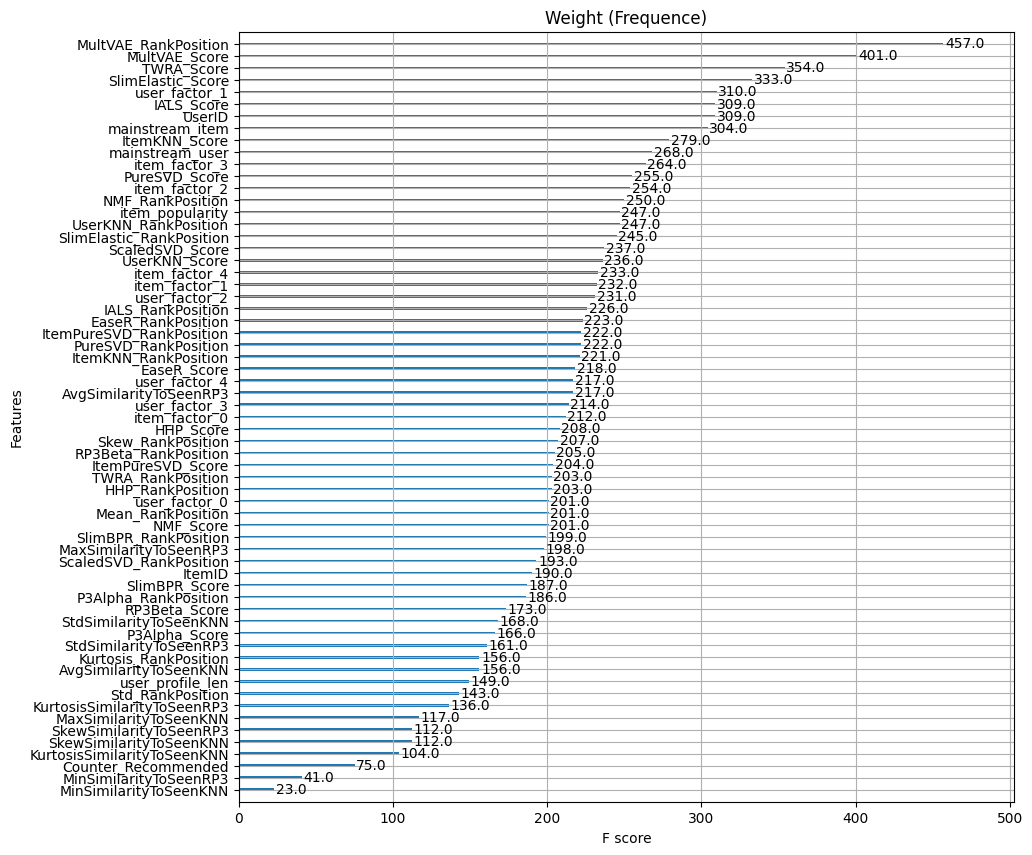

In [47]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)', ax=ax)

<Axes: title={'center': 'Feature Importance (Cover)'}, xlabel='F score', ylabel='Features'>

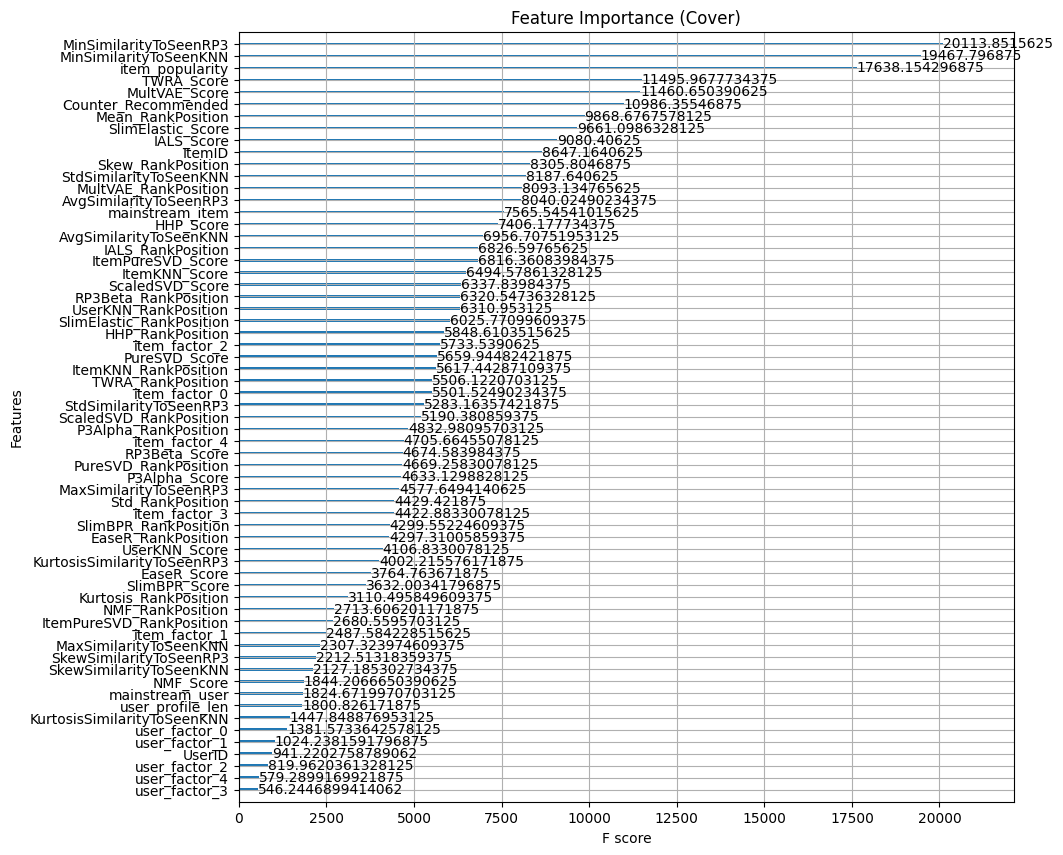

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='cover', title='Feature Importance (Cover)', ax=ax)

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='F score', ylabel='Features'>

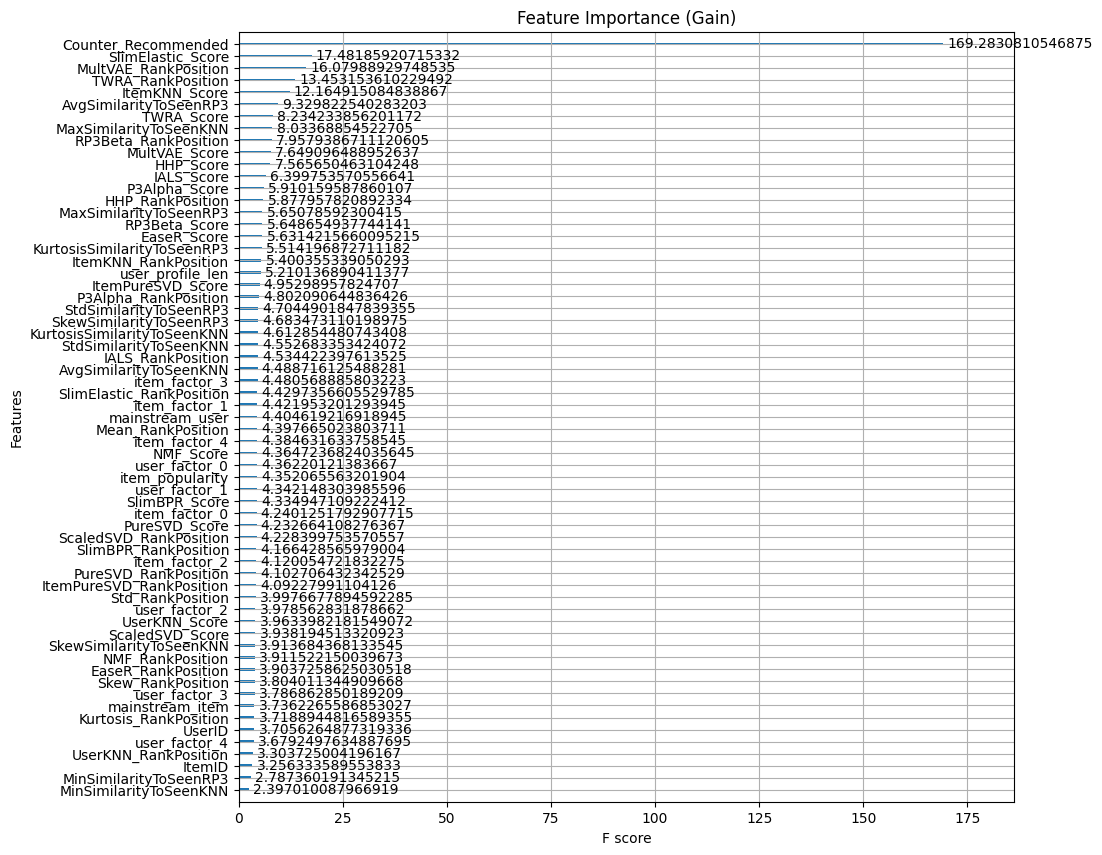

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='gain', title='Feature Importance (Gain)', ax=ax)

In [50]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1177.65 column/sec. Elapsed time 18.98 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 677.83 column/sec. Elapsed time 19.21 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2738.78 column/sec. Elapsed time 8.16 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [51]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [52]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.auto.tqdm(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,0,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,22283.0,...,0.000000,NaN,NaN,0,9156.800000,11035.400473,0.438355,-2.085596,0.886121,0.032075
1,0,1,0.000000,7496.0,0.0,0.090336,15.0,0.0,0.000000,7477.0,...,0.000000,NaN,NaN,0,2882.533333,3503.043184,0.552462,-1.858256,1.000000,0.032075
2,0,2,0.000000,7497.0,0.0,0.095367,13.0,0.0,0.000000,7478.0,...,0.000000,NaN,NaN,1,6234.400000,6389.856424,0.996430,1.372259,0.811388,0.032075
3,0,3,0.000000,7498.0,0.0,0.114379,6.0,1.0,0.000000,7479.0,...,0.000000,NaN,NaN,1,4535.466667,5395.874467,1.001751,0.531898,0.973665,0.032075
4,0,7,0.189751,24.0,0.0,0.075345,28.0,0.0,0.113997,12.0,...,0.000000,NaN,NaN,1,1601.933333,4587.783864,3.231372,10.713581,0.692527,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160066,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.014879,2.872438,6.805297,0,194.533333,377.837241,2.745526,7.327920,0.004982,0.056604
1160067,13023,13474,0.133842,40.0,0.0,0.080531,372.0,0.0,0.038993,120.0,...,0.009683,3.538551,10.568274,0,1669.000000,4544.525388,3.719381,14.095067,0.005694,0.056604
1160068,13023,13592,0.324246,9.0,1.0,0.085230,341.0,0.0,0.202384,18.0,...,0.018326,2.426400,4.940655,1,440.133333,608.235019,1.492203,1.741843,0.003559,0.056604
1160069,13023,20107,0.117283,44.0,0.0,0.055870,770.0,0.0,0.000000,15603.0,...,0.010866,2.507360,5.053177,0,1955.066667,3896.635774,3.488555,12.802630,0.002847,0.056604


In [53]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,22283.0,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
61,0,1421,0.315619,13.0,0.0,0.038471,136.0,0.0,0.113535,13.0,...,0.008304,-0.000813,0.007862,-0.005303,0.004007,0.005684,-0.001896,0.008995,-0.013853,-0.002147
60,0,1337,0.256143,15.0,0.0,0.024642,334.0,0.0,0.077940,33.0,...,0.007159,-0.012959,0.016733,0.007981,0.040655,0.005684,-0.001896,0.008995,-0.013853,-0.002147
58,0,1213,0.219015,17.0,0.0,0.035522,166.0,0.0,0.086829,25.0,...,0.007796,-0.009614,0.002953,-0.000483,-0.004862,0.005684,-0.001896,0.008995,-0.013853,-0.002147
57,0,1131,0.134693,40.0,0.0,0.000000,9769.0,0.0,0.000000,7813.0,...,0.008328,-0.008771,0.024645,0.012543,0.037796,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160027,13023,695,0.000000,7231.0,0.0,0.357792,15.0,0.0,0.000000,7257.0,...,0.011910,-0.020622,0.017123,0.012590,0.042566,0.006896,-0.007143,0.001571,0.006195,0.023549
1160024,13023,562,0.000000,7107.0,0.0,0.320286,22.0,0.0,0.000000,7304.0,...,0.016861,-0.024979,0.033671,0.028157,0.060212,0.006896,-0.007143,0.001571,0.006195,0.023549
1160023,13023,473,0.119352,43.0,0.0,0.335018,20.0,0.0,0.062268,69.0,...,0.018639,-0.017509,0.038689,0.037094,0.052088,0.006896,-0.007143,0.001571,0.006195,0.023549
1160040,13023,1775,0.522397,2.0,1.0,0.408252,5.0,1.0,0.584994,2.0,...,0.008148,-0.024127,0.008053,0.003610,0.029769,0.006896,-0.007143,0.001571,0.006195,0.023549


In [54]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [55]:
class XGBoostRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice)
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [56]:
recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 3.81 min. Users per second: 46


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.098919,0.171572,0.144909,0.049159,0.082439,0.268766,0.151972,0.117577,0.537012,0.358822,...,0.802826,0.431127,0.802826,0.054872,10.010333,0.996625,0.158327,0.771157,2.126514,0.292993


In [57]:
def objective_xgboost(trial):

    XGB_model = XGBRanker(
        objective = trial.suggest_categorical('objective', ["rank:map", "rank:pairwise", "rank:ndcg"]),
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        max_leaves = trial.suggest_int('max_leaves', 8, 1024),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = 'gbtree',
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        tree_method = 'hist',
        gamma = trial.suggest_float('gamma', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        # enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        group=groups,
        verbose=True
    )
    
    recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [58]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [59]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='xgboost_tuning_fixed_more_recommenders_more_candidates', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-12-28 18:37:53,253] Using an existing study with name 'xgboost_tuning_fixed_more_recommenders_more_candidates' instead of creating a new one.


EvaluatorHoldout: Processed 10456 (100.0%) in 5.14 min. Users per second: 34


[I 2023-12-28 18:53:10,994] Trial 249 finished with value: 0.04522220096914124 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1570, 'learning_rate': 0.024438025738094674, 'reg_alpha': 0.0006708878049745277, 'reg_lambda': 0.0006226087466227436, 'max_depth': 16, 'max_leaves': 59, 'grow_policy': 'lossguide', 'gamma': 0.001648046617123981, 'min_child_weight': 0.00011823034158441589, 'subsample': 0.10354306320624808, 'colsample_bytree': 0.6865683568497039}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.71 min. Users per second: 37


[I 2023-12-28 19:08:05,651] Trial 250 finished with value: 0.04540319373094847 and parameters: {'objective': 'rank:map', 'n_estimators': 1993, 'learning_rate': 0.033763757472411164, 'reg_alpha': 0.0005594899385212043, 'reg_lambda': 0.0007703678041591174, 'max_depth': 17, 'max_leaves': 33, 'grow_policy': 'lossguide', 'gamma': 0.0011588059862119632, 'min_child_weight': 5.100265290221342e-07, 'subsample': 0.31556618378181966, 'colsample_bytree': 0.7767531001520682}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.09 min. Users per second: 43


[I 2023-12-28 19:18:08,019] Trial 251 finished with value: 0.05266527307173876 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1389, 'learning_rate': 0.01615450904349016, 'reg_alpha': 0.0008624552299708813, 'reg_lambda': 0.00034696388673338913, 'max_depth': 16, 'max_leaves': 8, 'grow_policy': 'lossguide', 'gamma': 0.0008315121633286046, 'min_child_weight': 0.0008708328007647218, 'subsample': 0.1243313448049541, 'colsample_bytree': 0.8124927236399703}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 5.00 min. Users per second: 35


[I 2023-12-28 19:32:36,586] Trial 252 finished with value: 0.05165934573906112 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1565, 'learning_rate': 0.01421708632087314, 'reg_alpha': 0.0006920958385891156, 'reg_lambda': 0.001459452998625032, 'max_depth': 18, 'max_leaves': 46, 'grow_policy': 'lossguide', 'gamma': 0.0006284668830072098, 'min_child_weight': 0.001066148133134882, 'subsample': 0.12279423721151045, 'colsample_bytree': 0.8103255277368694}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.23 min. Users per second: 41


[I 2023-12-28 19:43:41,490] Trial 253 finished with value: 0.05237153650672234 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1417, 'learning_rate': 0.02122584062695509, 'reg_alpha': 0.0008082965679211014, 'reg_lambda': 0.00037151242457814684, 'max_depth': 17, 'max_leaves': 29, 'grow_policy': 'depthwise', 'gamma': 0.000968249113694917, 'min_child_weight': 0.0007299981531173869, 'subsample': 0.24978653651773897, 'colsample_bytree': 0.6911725301446547}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10000 (95.6%) in 5.29 min. Users per second: 31
EvaluatorHoldout: Processed 10456 (100.0%) in 5.54 min. Users per second: 31


[I 2023-12-28 20:01:18,166] Trial 254 finished with value: 0.03602533595049885 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1794, 'learning_rate': 0.03872410507736221, 'reg_alpha': 0.0011706111817408715, 'reg_lambda': 0.0003117902468895916, 'max_depth': 17, 'max_leaves': 70, 'grow_policy': 'lossguide', 'gamma': 0.0006545996606903014, 'min_child_weight': 4.618472549495567e-05, 'subsample': 0.1120784927137598, 'colsample_bytree': 0.7910616753913797}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.73 min. Users per second: 47


[I 2023-12-28 20:06:38,318] Trial 255 finished with value: 0.05230892720515952 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 337, 'learning_rate': 0.04892018706263777, 'reg_alpha': 0.0009358602492310772, 'reg_lambda': 0.0009611530786399685, 'max_depth': 16, 'max_leaves': 8, 'grow_policy': 'lossguide', 'gamma': 2.873337866749328, 'min_child_weight': 0.0008907935999596695, 'subsample': 0.12587213232156189, 'colsample_bytree': 0.7583786238390308}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.57 min. Users per second: 38


[I 2023-12-28 20:18:18,263] Trial 256 finished with value: 0.052599396108864785 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1262, 'learning_rate': 0.01185189073341986, 'reg_alpha': 0.0004929103006067863, 'reg_lambda': 0.0004461878474975171, 'max_depth': 16, 'max_leaves': 31, 'grow_policy': 'lossguide', 'gamma': 0.0007481657095297827, 'min_child_weight': 0.0005666987309714477, 'subsample': 0.10367537144202786, 'colsample_bytree': 0.8236913154743246}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.63 min. Users per second: 38


[I 2023-12-28 20:29:46,330] Trial 257 finished with value: 0.052335766811188185 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1086, 'learning_rate': 0.012560988952875194, 'reg_alpha': 0.00043531321994739704, 'reg_lambda': 0.0004487984769722137, 'max_depth': 16, 'max_leaves': 49, 'grow_policy': 'lossguide', 'gamma': 0.0008061151317415367, 'min_child_weight': 0.000613906468124788, 'subsample': 0.10036586489663367, 'colsample_bytree': 0.8230446690800443}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.89 min. Users per second: 36


[I 2023-12-28 20:42:28,354] Trial 258 finished with value: 0.051272873629176825 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1204, 'learning_rate': 0.009746393487615723, 'reg_alpha': 0.0005624796483934058, 'reg_lambda': 0.0005598337947192293, 'max_depth': 16, 'max_leaves': 85, 'grow_policy': 'lossguide', 'gamma': 0.0023343583155665797, 'min_child_weight': 0.0005302951897212594, 'subsample': 0.44560396047873707, 'colsample_bytree': 0.8123885195685525}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.10 min. Users per second: 43


[I 2023-12-28 20:51:14,360] Trial 259 finished with value: 0.04860254915534228 and parameters: {'objective': 'rank:map', 'n_estimators': 830, 'learning_rate': 0.01538228788427122, 'reg_alpha': 0.000364724674161904, 'reg_lambda': 0.0008138962608375597, 'max_depth': 13, 'max_leaves': 35, 'grow_policy': 'lossguide', 'gamma': 0.00038514256940505424, 'min_child_weight': 0.0012629000400239683, 'subsample': 0.10052347208250821, 'colsample_bytree': 0.8175930421099532}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.37 min. Users per second: 40


[I 2023-12-28 21:01:37,775] Trial 260 finished with value: 0.050180336193391316 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 963, 'learning_rate': 0.011390427320165132, 'reg_alpha': 0.0009708314438830086, 'reg_lambda': 0.00034199227451519226, 'max_depth': 16, 'max_leaves': 62, 'grow_policy': 'lossguide', 'gamma': 0.00046683085042488535, 'min_child_weight': 6.288786413102553e-05, 'subsample': 0.2332772875943065, 'colsample_bytree': 0.6618669333486001}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.52 min. Users per second: 39


[I 2023-12-28 21:13:17,090] Trial 261 finished with value: 0.05171720725398082 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1288, 'learning_rate': 0.026575672589040852, 'reg_alpha': 0.000420828125662964, 'reg_lambda': 0.0013450191672786753, 'max_depth': 16, 'max_leaves': 30, 'grow_policy': 'lossguide', 'gamma': 0.0010845772593617478, 'min_child_weight': 0.0007646532496545106, 'subsample': 0.1574578946182043, 'colsample_bytree': 0.7654755068507993}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.72 min. Users per second: 37


[I 2023-12-28 21:26:55,569] Trial 262 finished with value: 0.04948988808734476 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1631, 'learning_rate': 0.03172228803340419, 'reg_alpha': 3.36375113215657e-05, 'reg_lambda': 0.0004373585686381493, 'max_depth': 16, 'max_leaves': 29, 'grow_policy': 'lossguide', 'gamma': 5.435126259449419, 'min_child_weight': 9.71600398838435e-05, 'subsample': 0.12990594944638753, 'colsample_bytree': 0.7982147511922298}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.26 min. Users per second: 41


[I 2023-12-28 21:35:39,322] Trial 263 finished with value: 0.052259468247896484 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 731, 'learning_rate': 0.011380151006128825, 'reg_alpha': 0.0005485423287146533, 'reg_lambda': 0.0011590279382779208, 'max_depth': 18, 'max_leaves': 53, 'grow_policy': 'lossguide', 'gamma': 0.0008641177368443135, 'min_child_weight': 3.182383737622992e-05, 'subsample': 0.5213997338573932, 'colsample_bytree': 0.8421703929142235}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.13 min. Users per second: 42


[I 2023-12-28 21:44:22,338] Trial 264 finished with value: 0.052470606228975224 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 866, 'learning_rate': 0.017096743813872814, 'reg_alpha': 0.0007839487891362212, 'reg_lambda': 0.0005139157694373826, 'max_depth': 17, 'max_leaves': 28, 'grow_policy': 'lossguide', 'gamma': 0.3157817829342747, 'min_child_weight': 0.0004206274026641379, 'subsample': 0.48594184785460354, 'colsample_bytree': 0.7394695463240624}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.08 min. Users per second: 43


[I 2023-12-28 21:51:47,226] Trial 265 finished with value: 0.052318555610206714 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 534, 'learning_rate': 0.02374396185978455, 'reg_alpha': 0.0002782669600487146, 'reg_lambda': 0.0007038367786535233, 'max_depth': 16, 'max_leaves': 43, 'grow_policy': 'lossguide', 'gamma': 0.0002629765272629354, 'min_child_weight': 0.0012903551809741436, 'subsample': 0.14031723851131675, 'colsample_bytree': 0.8254924695696947}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.08 min. Users per second: 43


[I 2023-12-28 21:58:54,055] Trial 266 finished with value: 0.04591158642110306 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 432, 'learning_rate': 0.06346427137404696, 'reg_alpha': 0.0003050015236481088, 'reg_lambda': 0.0017855340930994675, 'max_depth': 15, 'max_leaves': 73, 'grow_policy': 'lossguide', 'gamma': 1.9690315166292207, 'min_child_weight': 0.0005664656744220664, 'subsample': 0.17281246479180132, 'colsample_bytree': 0.78693374709055}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.85 min. Users per second: 36


[I 2023-12-28 22:14:03,380] Trial 267 finished with value: 0.04598018833266592 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1998, 'learning_rate': 0.04506030610568244, 'reg_alpha': 0.0004414290698154081, 'reg_lambda': 0.0009087995751277632, 'max_depth': 16, 'max_leaves': 24, 'grow_policy': 'lossguide', 'gamma': 3.6844389250043905, 'min_child_weight': 0.00013825146814364268, 'subsample': 0.12410835688464783, 'colsample_bytree': 0.5632112309039744}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.45 min. Users per second: 39


[I 2023-12-28 22:25:04,777] Trial 268 finished with value: 0.04724698206239942 and parameters: {'objective': 'rank:map', 'n_estimators': 1089, 'learning_rate': 0.028457335301329007, 'reg_alpha': 0.1939936905748575, 'reg_lambda': 0.001525615665426969, 'max_depth': 17, 'max_leaves': 55, 'grow_policy': 'lossguide', 'gamma': 0.0004944176288590587, 'min_child_weight': 0.0003690094790304082, 'subsample': 0.28887182490925956, 'colsample_bytree': 0.8544264307451047}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.91 min. Users per second: 45


[I 2023-12-28 22:32:32,098] Trial 269 finished with value: 0.052407848914878874 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 773, 'learning_rate': 0.014496935030883165, 'reg_alpha': 5.183569414790556e-05, 'reg_lambda': 0.0011478229307262597, 'max_depth': 15, 'max_leaves': 9, 'grow_policy': 'lossguide', 'gamma': 0.0698237781686267, 'min_child_weight': 0.7176060199482154, 'subsample': 0.15282717258976675, 'colsample_bytree': 0.8721708666657237}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.31 min. Users per second: 40


[I 2023-12-28 22:42:05,668] Trial 270 finished with value: 0.04948841934759176 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 943, 'learning_rate': 0.036285261955074956, 'reg_alpha': 0.000698791887636368, 'reg_lambda': 0.00030937661666729133, 'max_depth': 18, 'max_leaves': 41, 'grow_policy': 'lossguide', 'gamma': 0.035328207846654865, 'min_child_weight': 0.3943895021753759, 'subsample': 0.27964188172096915, 'colsample_bytree': 0.6471351092114475}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.45 min. Users per second: 39


[I 2023-12-28 22:53:18,757] Trial 271 finished with value: 0.05268485626844503 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1251, 'learning_rate': 0.017986461951536768, 'reg_alpha': 0.00023338120846845293, 'reg_lambda': 0.9207457588589191, 'max_depth': 12, 'max_leaves': 26, 'grow_policy': 'lossguide', 'gamma': 6.4560441733508585, 'min_child_weight': 0.0009003407915485955, 'subsample': 0.11276532487597414, 'colsample_bytree': 0.7276285057489198}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 5.21 min. Users per second: 33


[I 2023-12-28 23:08:43,030] Trial 272 finished with value: 0.043037721942896436 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1488, 'learning_rate': 0.01845276125139244, 'reg_alpha': 0.00032499762796097824, 'reg_lambda': 0.02677750229431078, 'max_depth': 11, 'max_leaves': 97, 'grow_policy': 'lossguide', 'gamma': 0.0013708656224655253, 'min_child_weight': 0.000924905947313259, 'subsample': 0.26974941327688695, 'colsample_bytree': 0.8160643060755656}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10000 (95.6%) in 5.40 min. Users per second: 31
EvaluatorHoldout: Processed 10456 (100.0%) in 5.64 min. Users per second: 31


[I 2023-12-28 23:25:46,148] Trial 273 finished with value: 0.039271892192225474 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1290, 'learning_rate': 0.013675761846824517, 'reg_alpha': 0.00022555702569296944, 'reg_lambda': 0.0004039312705433165, 'max_depth': 14, 'max_leaves': 248, 'grow_policy': 'depthwise', 'gamma': 2.635945609923392, 'min_child_weight': 0.0016617152385980042, 'subsample': 0.11121771818225033, 'colsample_bytree': 0.7710467098715712}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.99 min. Users per second: 35


[I 2023-12-28 23:39:33,172] Trial 274 finished with value: 0.05254332212992367 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1319, 'learning_rate': 0.003153053869870975, 'reg_alpha': 0.00023729161701725786, 'reg_lambda': 0.0005886666074945946, 'max_depth': 12, 'max_leaves': 69, 'grow_policy': 'lossguide', 'gamma': 0.0017927915746523099, 'min_child_weight': 0.0058133720735352576, 'subsample': 0.10137471889879879, 'colsample_bytree': 0.7348251305487821}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.77 min. Users per second: 37


[I 2023-12-28 23:53:55,599] Trial 275 finished with value: 0.05235664416876201 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1781, 'learning_rate': 0.017145795786571404, 'reg_alpha': 2.2089681147871977e-05, 'reg_lambda': 0.023063657716462325, 'max_depth': 13, 'max_leaves': 27, 'grow_policy': 'lossguide', 'gamma': 0.1277615141199685, 'min_child_weight': 6.209197509348144e-05, 'subsample': 0.13946580155619284, 'colsample_bytree': 0.8020387467080863}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.04 min. Users per second: 43


[I 2023-12-29 00:03:24,778] Trial 276 finished with value: 0.05061892389575107 and parameters: {'objective': 'rank:map', 'n_estimators': 1153, 'learning_rate': 0.021355361164354672, 'reg_alpha': 3.5946175611087024e-05, 'reg_lambda': 0.014400709432239072, 'max_depth': 17, 'max_leaves': 48, 'grow_policy': 'lossguide', 'gamma': 5.608615985578788, 'min_child_weight': 0.003431581432327264, 'subsample': 0.3884736264286818, 'colsample_bytree': 0.834260740428386}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.65 min. Users per second: 37


[I 2023-12-29 00:16:10,386] Trial 277 finished with value: 0.05251735921351507 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1483, 'learning_rate': 0.016001436386921898, 'reg_alpha': 0.0005285813798398305, 'reg_lambda': 0.03845380881021734, 'max_depth': 18, 'max_leaves': 28, 'grow_policy': 'lossguide', 'gamma': 3.774702453630447, 'min_child_weight': 8.918601302220323e-05, 'subsample': 0.11601311458613306, 'colsample_bytree': 0.7226295526530921}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.89 min. Users per second: 45


[I 2023-12-29 00:23:20,025] Trial 278 finished with value: 0.05153682931346516 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 666, 'learning_rate': 0.002182999256494077, 'reg_alpha': 0.001304184543680868, 'reg_lambda': 0.30293916057826464, 'max_depth': 12, 'max_leaves': 8, 'grow_policy': 'lossguide', 'gamma': 1.5288307425837888, 'min_child_weight': 0.0001534370416768773, 'subsample': 0.6600134097661983, 'colsample_bytree': 0.7867664906001399}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.48 min. Users per second: 39


[I 2023-12-29 00:34:03,431] Trial 279 finished with value: 0.05187484819227415 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1006, 'learning_rate': 0.011294631497314519, 'reg_alpha': 0.00031654418273999044, 'reg_lambda': 0.008461902985627488, 'max_depth': 9, 'max_leaves': 81, 'grow_policy': 'lossguide', 'gamma': 0.0794993198182668, 'min_child_weight': 0.00025696739107202, 'subsample': 0.5919955017903918, 'colsample_bytree': 0.6121916883850196}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.66 min. Users per second: 48


[I 2023-12-29 00:38:06,082] Trial 280 finished with value: 0.050485143336855665 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 30, 'learning_rate': 0.022104003011269586, 'reg_alpha': 1.4524433877604357e-05, 'reg_lambda': 0.0002772454827896448, 'max_depth': 14, 'max_leaves': 47, 'grow_policy': 'lossguide', 'gamma': 6.957325101978331, 'min_child_weight': 4.4037548517099734e-05, 'subsample': 0.20589034821888813, 'colsample_bytree': 0.684657961435072}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.01 min. Users per second: 43


[I 2023-12-29 00:45:17,011] Trial 281 finished with value: 0.05245746347506157 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 570, 'learning_rate': 0.018788859051307602, 'reg_alpha': 3.355766538333534e-05, 'reg_lambda': 0.08204702707404728, 'max_depth': 15, 'max_leaves': 31, 'grow_policy': 'lossguide', 'gamma': 2.3759164380826725, 'min_child_weight': 0.0001852288750692343, 'subsample': 0.5165075554776435, 'colsample_bytree': 0.7529426046854033}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.67 min. Users per second: 47


[I 2023-12-29 00:49:25,711] Trial 282 finished with value: 0.05213716055792432 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 41, 'learning_rate': 0.02510842487285692, 'reg_alpha': 5.8331233047207015e-05, 'reg_lambda': 0.14899219209228332, 'max_depth': 17, 'max_leaves': 61, 'grow_policy': 'lossguide', 'gamma': 4.437906447112806, 'min_child_weight': 0.0007847522443573101, 'subsample': 0.18121646530212762, 'colsample_bytree': 0.6230288274801135}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.63 min. Users per second: 48


[I 2023-12-29 00:53:18,897] Trial 283 finished with value: 0.051472713320217675 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 16, 'learning_rate': 0.012722003381277427, 'reg_alpha': 0.0009787956091513931, 'reg_lambda': 0.7992399159670102, 'max_depth': 16, 'max_leaves': 8, 'grow_policy': 'lossguide', 'gamma': 0.4742901866811761, 'min_child_weight': 0.0003236603950595137, 'subsample': 0.5551595920262886, 'colsample_bytree': 0.4695645447998704}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.77 min. Users per second: 46


[I 2023-12-29 00:58:36,855] Trial 284 finished with value: 0.05193859225659196 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 232, 'learning_rate': 0.007703760261052778, 'reg_alpha': 4.4154714721668694e-05, 'reg_lambda': 0.000805585710766843, 'max_depth': 17, 'max_leaves': 28, 'grow_policy': 'lossguide', 'gamma': 3.4787911164372436, 'min_child_weight': 0.02388580146645128, 'subsample': 0.5434893361781553, 'colsample_bytree': 0.8798500891211737}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.59 min. Users per second: 38


[I 2023-12-29 01:10:14,234] Trial 285 finished with value: 0.052131657527842074 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1205, 'learning_rate': 0.010153168108629798, 'reg_alpha': 0.00020546467158973604, 'reg_lambda': 0.8733334713715382, 'max_depth': 16, 'max_leaves': 55, 'grow_policy': 'lossguide', 'gamma': 6.6031894780815, 'min_child_weight': 0.0019714538670061615, 'subsample': 0.573584879710939, 'colsample_bytree': 0.8471060998784119}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.88 min. Users per second: 45


[I 2023-12-29 01:16:49,655] Trial 286 finished with value: 0.05030464774535206 and parameters: {'objective': 'rank:map', 'n_estimators': 483, 'learning_rate': 0.020272392479022305, 'reg_alpha': 0.602070062691261, 'reg_lambda': 0.0001931519138691857, 'max_depth': 10, 'max_leaves': 26, 'grow_policy': 'lossguide', 'gamma': 1.8904173672372273, 'min_child_weight': 0.0001123192973760306, 'subsample': 0.12613627198890393, 'colsample_bytree': 0.8700744013446239}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.69 min. Users per second: 47


[I 2023-12-29 01:21:19,583] Trial 287 finished with value: 0.05201759679260689 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 98, 'learning_rate': 0.015640345243030616, 'reg_alpha': 0.00016741239461554716, 'reg_lambda': 0.0027458906422842258, 'max_depth': 15, 'max_leaves': 46, 'grow_policy': 'lossguide', 'gamma': 0.22636208475420755, 'min_child_weight': 0.0012258184705148973, 'subsample': 0.7446737048509074, 'colsample_bytree': 0.7168613536927915}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.84 min. Users per second: 45


[I 2023-12-29 01:27:15,416] Trial 288 finished with value: 0.052434259664080184 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 368, 'learning_rate': 0.02499031444908168, 'reg_alpha': 0.0031528395580171916, 'reg_lambda': 0.5055737871745944, 'max_depth': 7, 'max_leaves': 25, 'grow_policy': 'lossguide', 'gamma': 0.02583576585404568, 'min_child_weight': 0.00022819830868441176, 'subsample': 0.16035376020680647, 'colsample_bytree': 0.8862724941723694}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.38 min. Users per second: 40


[I 2023-12-29 01:36:22,411] Trial 289 finished with value: 0.052308088467471106 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 668, 'learning_rate': 0.004477868976122126, 'reg_alpha': 2.8336556886728908e-05, 'reg_lambda': 0.0009773259958249158, 'max_depth': 17, 'max_leaves': 78, 'grow_policy': 'lossguide', 'gamma': 0.003090396222249246, 'min_child_weight': 0.0004384059717966322, 'subsample': 0.1420442331322876, 'colsample_bytree': 0.8252571671601865}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.89 min. Users per second: 45


[I 2023-12-29 01:43:45,589] Trial 290 finished with value: 0.051816170710825 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 765, 'learning_rate': 0.0062202658045619405, 'reg_alpha': 0.00041983842050351885, 'reg_lambda': 0.004352295361244923, 'max_depth': 11, 'max_leaves': 8, 'grow_policy': 'lossguide', 'gamma': 0.9809027255410432, 'min_child_weight': 7.723162239370112e-06, 'subsample': 0.11495160808448776, 'colsample_bytree': 0.11374356148954967}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.21 min. Users per second: 41


[I 2023-12-29 01:53:42,100] Trial 291 finished with value: 0.05111092894184003 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1048, 'learning_rate': 0.030791104837427537, 'reg_alpha': 0.00024798226511260277, 'reg_lambda': 0.0020811775273111427, 'max_depth': 10, 'max_leaves': 43, 'grow_policy': 'depthwise', 'gamma': 0.0008883311729475249, 'min_child_weight': 0.2863286089646338, 'subsample': 0.13093075396414444, 'colsample_bytree': 0.7725014838252948}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.43 min. Users per second: 39


[I 2023-12-29 02:04:17,434] Trial 292 finished with value: 0.042139456649786036 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 837, 'learning_rate': 0.017978696134611043, 'reg_alpha': 0.0008683167251809097, 'reg_lambda': 0.0004893946079578428, 'max_depth': 18, 'max_leaves': 820, 'grow_policy': 'lossguide', 'gamma': 4.74739948573325, 'min_child_weight': 0.00014642433660582156, 'subsample': 0.4552610602787134, 'colsample_bytree': 0.8429952152841297}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 5.00 min. Users per second: 35


[I 2023-12-29 02:18:26,232] Trial 293 finished with value: 0.039545233389199075 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1385, 'learning_rate': 0.037880393116526204, 'reg_alpha': 0.00010407032272642237, 'reg_lambda': 0.00022678400528642568, 'max_depth': 16, 'max_leaves': 64, 'grow_policy': 'lossguide', 'gamma': 2.891050944065809, 'min_child_weight': 0.0007369725838553692, 'subsample': 0.15436080348956005, 'colsample_bytree': 0.8077561944845264}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.19 min. Users per second: 42


[I 2023-12-29 02:30:24,328] Trial 294 finished with value: 0.05154489030373742 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1610, 'learning_rate': 0.00019493081183311615, 'reg_alpha': 0.0006737786292402192, 'reg_lambda': 0.05100473359805464, 'max_depth': 17, 'max_leaves': 8, 'grow_policy': 'lossguide', 'gamma': 0.0003275112609823568, 'min_child_weight': 7.911262889372468e-05, 'subsample': 0.3804859394689305, 'colsample_bytree': 0.7040246275133036}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.62 min. Users per second: 38


[I 2023-12-29 02:41:12,019] Trial 295 finished with value: 0.03248699387304037 and parameters: {'objective': 'rank:map', 'n_estimators': 606, 'learning_rate': 0.0804998476630366, 'reg_alpha': 0.01794640233100445, 'reg_lambda': 0.00069271915813769, 'max_depth': 15, 'max_leaves': 489, 'grow_policy': 'lossguide', 'gamma': 1.2468492504397468, 'min_child_weight': 0.0002948326065407392, 'subsample': 0.10103652837469008, 'colsample_bytree': 0.5944813419624968}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.35 min. Users per second: 40


[I 2023-12-29 02:51:04,233] Trial 296 finished with value: 0.0523802350894455 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 959, 'learning_rate': 0.008876510130634558, 'reg_alpha': 1.0714266216221506e-05, 'reg_lambda': 0.0012510180581053265, 'max_depth': 16, 'max_leaves': 38, 'grow_policy': 'lossguide', 'gamma': 5.462055539580308, 'min_child_weight': 0.00019082181372058693, 'subsample': 0.41741873627904436, 'colsample_bytree': 0.6634690055613873}. Best is trial 213 with value: 0.05284310823283718.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.37 min. Users per second: 40


[I 2023-12-29 03:02:30,623] Trial 297 finished with value: 0.05187861302388896 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1151, 'learning_rate': 0.0006647509416618226, 'reg_alpha': 0.00019726667167046188, 'reg_lambda': 0.0019429967788030494, 'max_depth': 18, 'max_leaves': 27, 'grow_policy': 'lossguide', 'gamma': 0.0005191164781974588, 'min_child_weight': 0.00010634573273099071, 'subsample': 0.6172939053096964, 'colsample_bytree': 0.630911394428111}. Best is trial 213 with value: 0.05284310823283718.


In [60]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [61]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [62]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [63]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost.json', 
            'tuning_results/best_params_hybrid_xgboost.json', 
            'XGBoost tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/xgboost/best_params_hybrid_xgboost.json', 
        '/kaggle/working/best_params_hybrid_xgboost.json'
    )

In [64]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [65]:
with open('/kaggle/working/best_params_hybrid_xgboost.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['tree_method'] = 'hist'
xgboost_params['booster'] = 'gbtree'
xgboost_params

{'objective': 'rank:map',
 'n_estimators': 923,
 'learning_rate': 0.016233584603675216,
 'reg_alpha': 0.00026966712997435194,
 'reg_lambda': 0.0010772980082167445,
 'max_depth': 17,
 'max_leaves': 9,
 'grow_policy': 'lossguide',
 'gamma': 0.01884301564566057,
 'min_child_weight': 0.00014490780529314494,
 'subsample': 0.6083091004075291,
 'colsample_bytree': 0.8883474567274562,
 'tree_method': 'hist',
 'booster': 'gbtree'}

In [66]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1106.28 column/sec. Elapsed time 20.20 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 679.71 column/sec. Elapsed time 19.16 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2512.67 column/sec. Elapsed time 8.89 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [67]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [68]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_19/4000761057.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
61,0,1421,False,0.315619,13.0,0.0,0.038471,136.0,0.0,0.113535,...,0.008691,-0.001058,0.007296,-0.006656,0.002400,0.005573,0.000276,0.007794,-0.010626,-0.001530
60,0,1337,False,0.256143,15.0,0.0,0.024642,334.0,0.0,0.077940,...,0.008009,-0.013008,0.019273,0.015060,0.043675,0.005573,0.000276,0.007794,-0.010626,-0.001530
58,0,1213,False,0.219015,17.0,0.0,0.035522,166.0,0.0,0.086829,...,0.007025,-0.009459,0.005387,-0.001226,-0.007530,0.005573,0.000276,0.007794,-0.010626,-0.001530
57,0,1131,True,0.134693,40.0,0.0,0.000000,9769.0,0.0,0.000000,...,0.007742,-0.007760,0.024237,0.015334,0.037378,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160027,13023,695,False,0.000000,7231.0,0.0,0.357792,15.0,0.0,0.000000,...,0.013243,-0.025955,0.025042,0.020921,0.052559,0.009693,-0.007923,-0.000422,0.004503,0.023066
1160024,13023,562,False,0.000000,7107.0,0.0,0.320286,22.0,0.0,0.000000,...,0.016208,-0.027309,0.038131,0.034664,0.064509,0.009693,-0.007923,-0.000422,0.004503,0.023066
1160023,13023,473,False,0.119352,43.0,0.0,0.335018,20.0,0.0,0.062268,...,0.019064,-0.020487,0.043671,0.041667,0.057763,0.009693,-0.007923,-0.000422,0.004503,0.023066
1160040,13023,1775,False,0.522397,2.0,1.0,0.408252,5.0,1.0,0.584994,...,0.008526,-0.025291,0.011833,0.007266,0.036316,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [69]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

array([ 83,  73,  96, ..., 105,  70,  71])

In [70]:
XGB_model = XGBRanker(**xgboost_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.8883474567274562, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=0.01884301564566057,
          grow_policy='lossguide', importance_type=None,
          interaction_constraints=None, learning_rate=0.016233584603675216,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=17, max_leaves=9,
          min_child_weight=0.00014490780529314494, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=923,
          n_jobs=None, num_parallel_tree=None, objective='rank:map', ...)

<Axes: title={'center': 'Feature Importance (Weight)'}, xlabel='F score', ylabel='Features'>

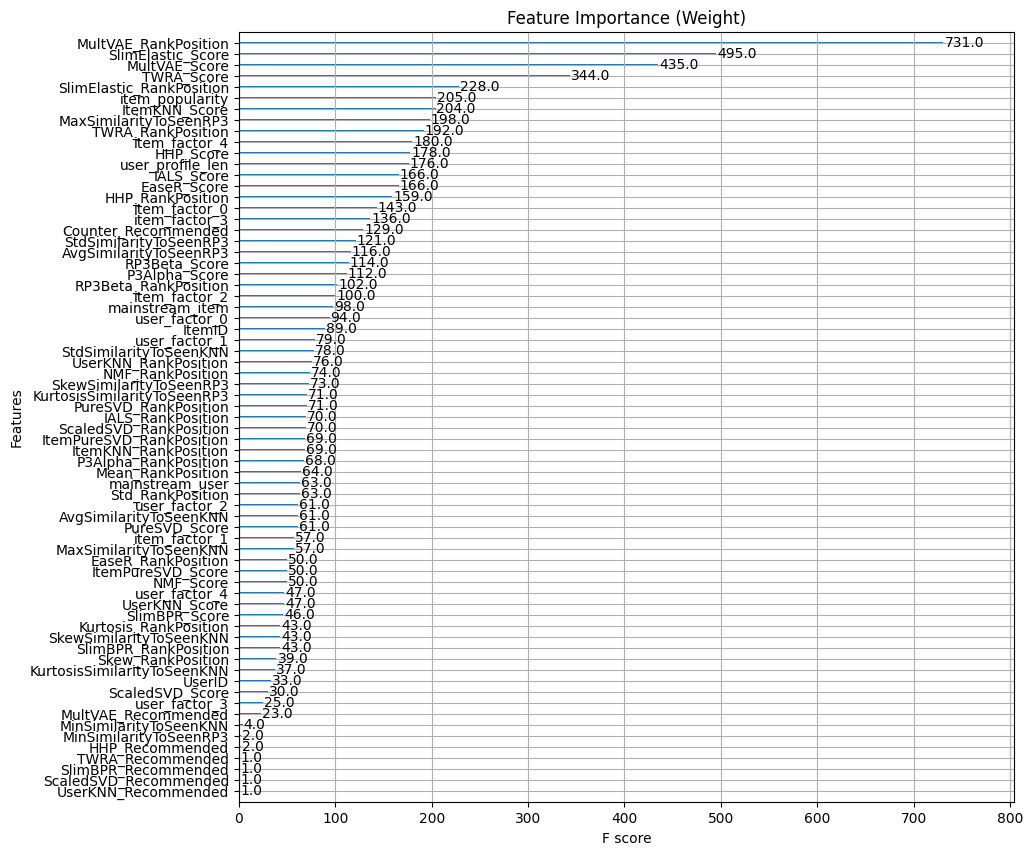

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Feature Importance (Weight)', ax=ax)

<Axes: title={'center': 'Feature Importance (Cover)'}, xlabel='F score', ylabel='Features'>

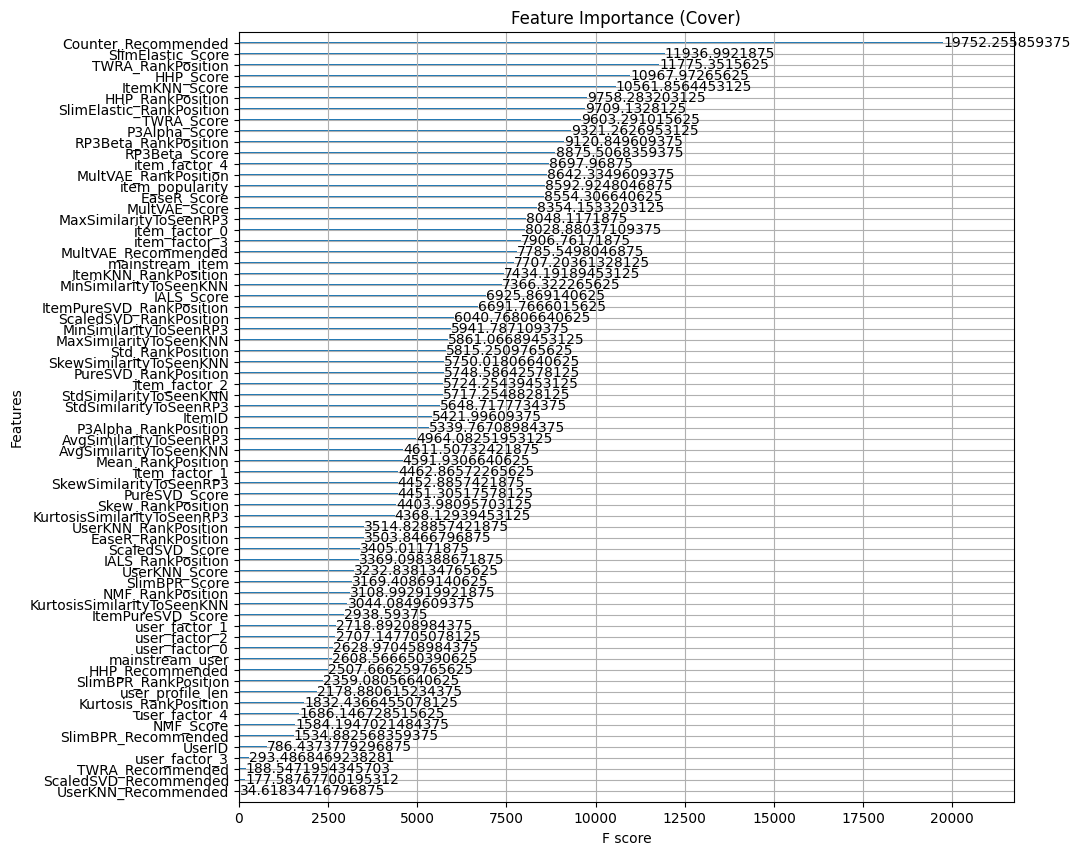

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='cover', title='Feature Importance (Cover)', ax=ax)

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='F score', ylabel='Features'>

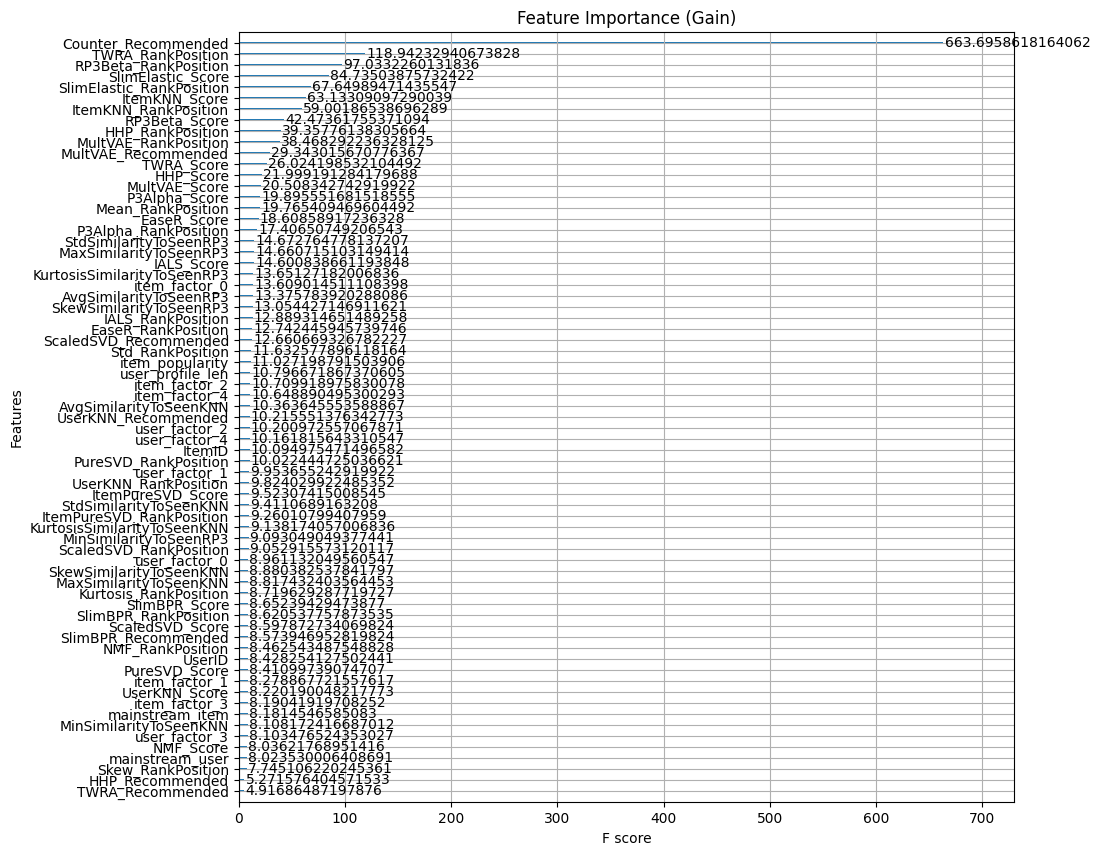

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='gain', title='Feature Importance (Gain)', ax=ax)

In [74]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

recommender_hhp = HHPRecommender(URM_all)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_all)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_rp3_recall = RP3betaRecommender(URM_all)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_all)
recommender_item_recall.fit(**params_item_knn)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1016.58 column/sec. Elapsed time 21.98 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 609.57 column/sec. Elapsed time 21.37 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2529.73 column/sec. Elapsed time 8.83 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity colu

In [75]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [76]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_19/3716254121.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/3716254121.py:74: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/tmp/ipykernel_19/3716254121.py:75: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22150.0,0.0,0.056352,116.0,0.0,0.000000,22150.0,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
52,0,1088,0.154091,32.0,0.0,0.023720,533.0,0.0,0.044536,64.0,...,0.011559,-0.010351,0.023728,0.026254,0.054192,0.005573,0.000276,0.007794,-0.010626,-0.001530
51,0,1082,0.257622,16.0,0.0,0.028504,397.0,0.0,0.088188,20.0,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
50,0,1067,0.000000,8334.0,0.0,0.062167,98.0,0.0,0.028730,174.0,...,0.006633,0.003640,0.012813,-0.006771,0.000972,0.005573,0.000276,0.007794,-0.010626,-0.001530
49,0,1056,0.148159,35.0,0.0,0.005110,4317.0,0.0,0.084663,23.0,...,0.002581,-0.001164,0.000103,-0.001671,0.001920,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140288,13023,562,0.115758,51.0,0.0,0.466899,15.0,0.0,0.000000,7076.0,...,0.016208,-0.027309,0.038131,0.034664,0.064509,0.009693,-0.007923,-0.000422,0.004503,0.023066
1140283,13023,407,0.000000,7162.0,0.0,0.358814,32.0,0.0,0.000000,7125.0,...,0.020133,-0.039630,0.018026,0.009485,0.061210,0.009693,-0.007923,-0.000422,0.004503,0.023066
1140279,13023,328,0.145361,40.0,0.0,0.491791,9.0,1.0,0.132055,39.0,...,0.021672,-0.033972,0.021341,0.030813,0.063417,0.009693,-0.007923,-0.000422,0.004503,0.023066
1140294,13023,798,0.167712,34.0,0.0,0.453557,18.0,0.0,0.135379,38.0,...,0.011918,-0.029147,0.021763,0.012855,0.062526,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [77]:
recommender = XGBoostRerankerRecommender(URM_all, XGB_model, prediction_dataframe)

In [78]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost.csv', index=False)

,user_id,item_list
0,1,36 101 506 403 123 515 1546 694 977 52
1,2,1095 1522 12 47 196 3176 2 5 50 3
2,3,59 4252 259 648 857 536 239 584 956 9
3,4,249 28 50 7 5 3 2 146 171 1
4,5,1570 5138 77 131 1220 471 1511 7033 170 766
